In [1]:
import os
import glob
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# to ensure reproducibility of results
tf.keras.utils.set_random_seed(111)

import warnings
warnings.filterwarnings('ignore')

### **Accessing the data**

In [4]:
class_dirs = os.listdir("clothing-dataset-small/train")
class_dirs

['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

#### Let us analyze the data distribution and visualize the sample images

glob is a python library useful for working with file paths and retrieving lists of files with specific extensions.

In [5]:
image_dict = {} # dict to store image array for every class
count_dict = {} # dict to store count of files for every class

for cls in class_dirs:

    file_paths = glob.glob(f'clothing-dataset-small/train/{cls}/*')
    count_dict[cls] = len(file_paths)
    image_path = random.choice(file_paths)

    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

In [6]:
image_dict

{'dress': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=533x400>,
 'hat': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'longsleeve': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'outwear': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'pants': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x534>,
 'shirt': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'shoes': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x711>,
 'shorts': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'skirt': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x447>,
 't-shirt': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>}

In [ ]:
count_dict

{'dress': 241,
 'hat': 123,
 'longsleeve': 455,
 'outwear': 184,
 'pants': 468,
 'shirt': 290,
 'shoes': 198,
 'shorts': 202,
 'skirt': 112,
 't-shirt': 795}

#### Vizualizing random sample from each class

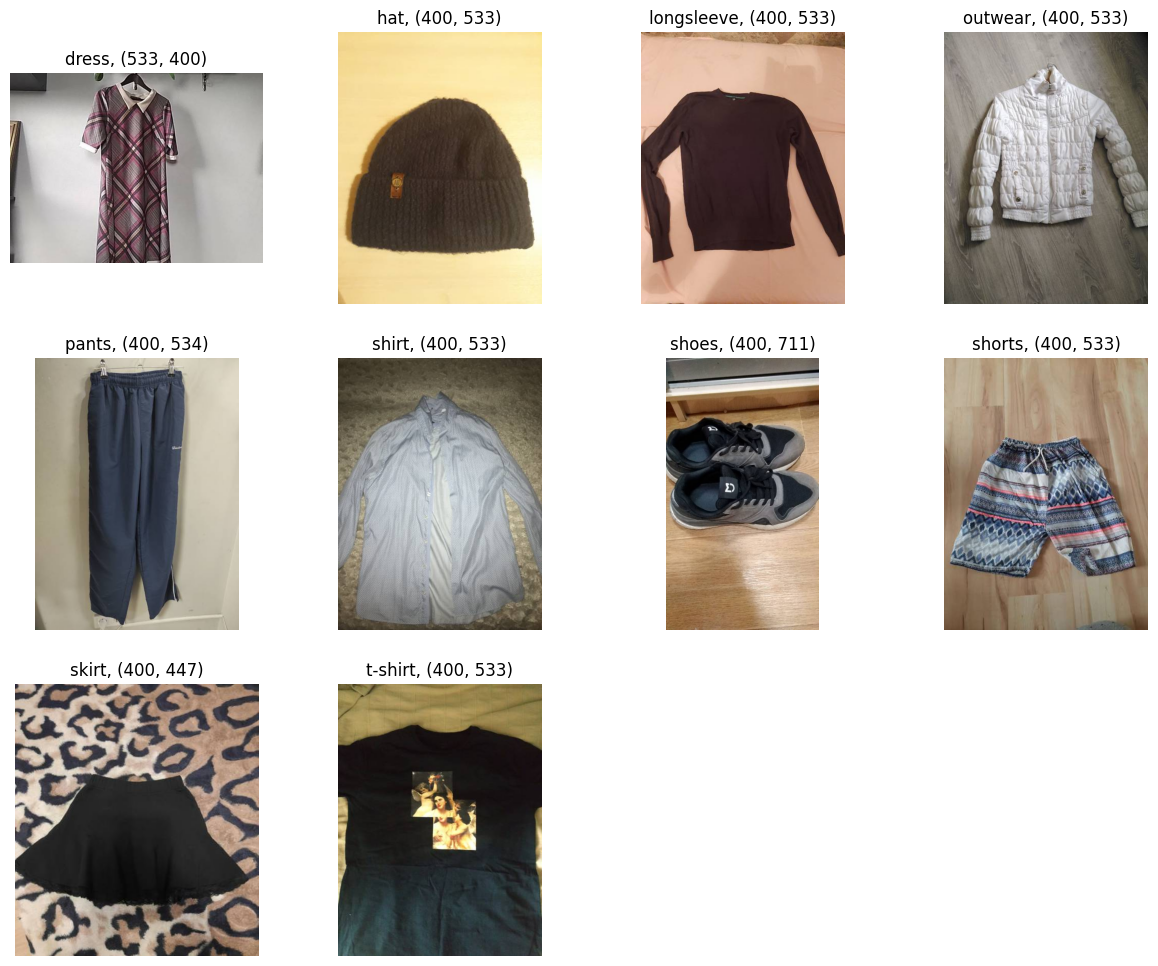

In [8]:
plt.figure(figsize=(15, 12))

for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)            # assuming the images to be at most 12
    plt.imshow(img)
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")         # remove x and y label to make the code cleaner

Here, every image has different dimension. This is expected in a real-world data, but batching requires all samples to be of the same size.

#### Visualizing the distribution of Training Data across Classes

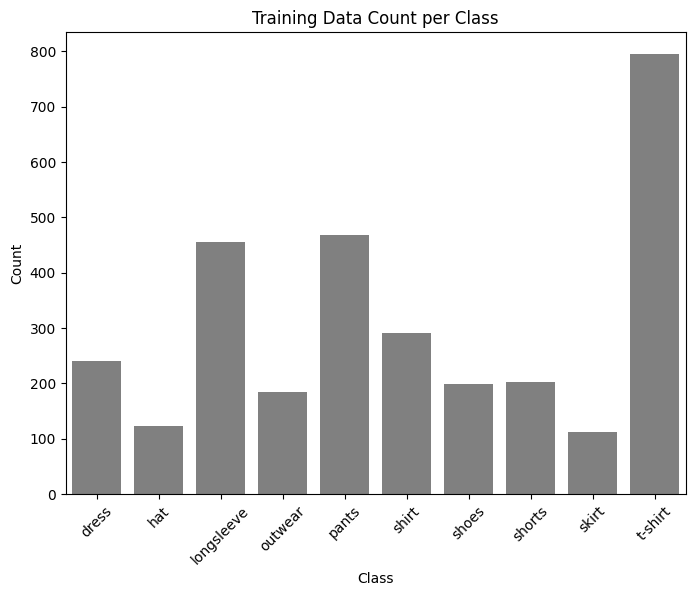

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(count_dict.keys()), y=list(count_dict.values()), color='grey')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Training Data Count per Class")
plt.xticks(rotation=45)
plt.show()

### **Data Preprocessing**

Types of preprocessing required here:
1. Shape Preprocessing
2. Value Preprocessing

Keras provides a utility function (tf.keras.utils.image_dataset_from_directory) to directly load data from directory in tf.data.Dataset format

In [10]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/test", shuffle = False,
)


Loading Train Data...
Found 3068 files belonging to 10 classes.

Loading Validation Data...
Found 341 files belonging to 10 classes.

Loading Test Data...
Found 372 files belonging to 10 classes.


#### Shape Preprocessing (Resizing)
- The dataset consists of images of different sizes, but a batch require images of the same size
- Resizing all the images to a fixed size (128,128)

#### Value Preprocessing (Rescaling)
- Converting the datatype of input tensor from int to float and rescaling the values to lie between 0 and 1 instead of 0 and 255
- Without scaling, the high pixel range images will have large influence on loss values and on weight updation, (ex: Black cat vs White cat)

In [11]:
height, width = 128, 128       # optional value

In [12]:
data_preprocess = keras.Sequential(
                        name="data_preprocess",
                        layers=[
                            layers.Resizing(height, width),   # Shape Preprocessing
                            layers.Rescaling(1.0/255),        # Value Preprocessing
                        ]
                  )

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

### **Building a Neural Network**

In [44]:
num_classes = 10
hidden_size_1 = 1024
hidden_size_2 = 256

model = keras.Sequential(
                name="ANN_Model",
                layers=[
                    layers.Flatten(input_shape=(height, width, 3)),          # alternatively, input_shape=next(iter(train_ds))[0].shape[1:]
                    layers.Dense(units=hidden_size_1, activation='relu'),
                    layers.Dense(units=hidden_size_2, activation='relu'),
                    layers.Dense(units=num_classes, activation='softmax'),
                ]
            )

To visualize the Model Structure, run the below cell in Google Colab

In [45]:
# tf.keras.utils.plot_model(model, to_file="ANN_Model.png", show_shapes=True)

In [46]:
model.summary()

Model: "ANN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_7 (Dense)             (None, 1024)              50332672  
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 50597642 (193.01 MB)
Trainable params: 50597642 (193.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 [==============================] - 66s 677ms/step - loss: 2.2710 - accuracy: 0.3859 - val_loss: 1.7326 - val_accuracy: 0.4370
Epoch 2/10
96/96 [==============================] - 73s 754ms/step - loss: 1.6829 - accuracy: 0.4596 - val_loss: 1.9395 - val_accuracy: 0.4076
Epoch 3/10
96/96 [==============================] - 65s 666ms/step - loss: 1.6740 - accuracy: 0.4527 - val_loss: 1.9084 - val_accuracy: 0.3812
Epoch 4/10
96/96 [==============================] - 63s 642ms/step - loss: 1.5810 - accuracy: 0.4798 - val_loss: 1.6364 - val_accuracy: 0.4839
Epoch 5/10
96/96 [==============================] - 63s 649ms/step - loss: 1.5658 - accuracy: 0.4837 - val_loss: 1.9082 - val_accuracy: 0.3167
Epoch 6/10
96/96 [==============================] - 65s 675ms/step - loss: 1.5374 - accuracy: 0.4922 - val_loss: 1.5629 - val_accuracy: 0.4839
Epoch 7/10
96/96 [==============================] - 57s 585ms/step - loss: 1.4489 - accuracy: 0.5186 - val_loss: 1.5924 - val_accuracy: 0.4839

#### Performance Check

In [19]:
params = model_fit.params
params

{'verbose': 1, 'epochs': 10, 'steps': 96}

In [20]:
history = model_fit.history
history

{'loss': [2.2709829807281494,
  1.6828935146331787,
  1.6740143299102783,
  1.5809881687164307,
  1.5658044815063477,
  1.5374395847320557,
  1.4488545656204224,
  1.3935695886611938,
  1.3229057788848877,
  1.3512461185455322],
 'accuracy': [0.38591915369033813,
  0.45958277583122253,
  0.4527379274368286,
  0.47979140281677246,
  0.48370274901390076,
  0.4921773076057434,
  0.5185788869857788,
  0.5244458913803101,
  0.5511733889579773,
  0.5466101765632629],
 'val_loss': [1.7325602769851685,
  1.9395415782928467,
  1.9084384441375732,
  1.6364270448684692,
  1.9082040786743164,
  1.5628926753997803,
  1.5924043655395508,
  1.5396300554275513,
  1.5754591226577759,
  1.7503405809402466],
 'val_accuracy': [0.436950147151947,
  0.40762463212013245,
  0.3812316656112671,
  0.4838709533214569,
  0.3167155385017395,
  0.4838709533214569,
  0.4838709533214569,
  0.4868035316467285,
  0.47507330775260925,
  0.4457477927207947]}

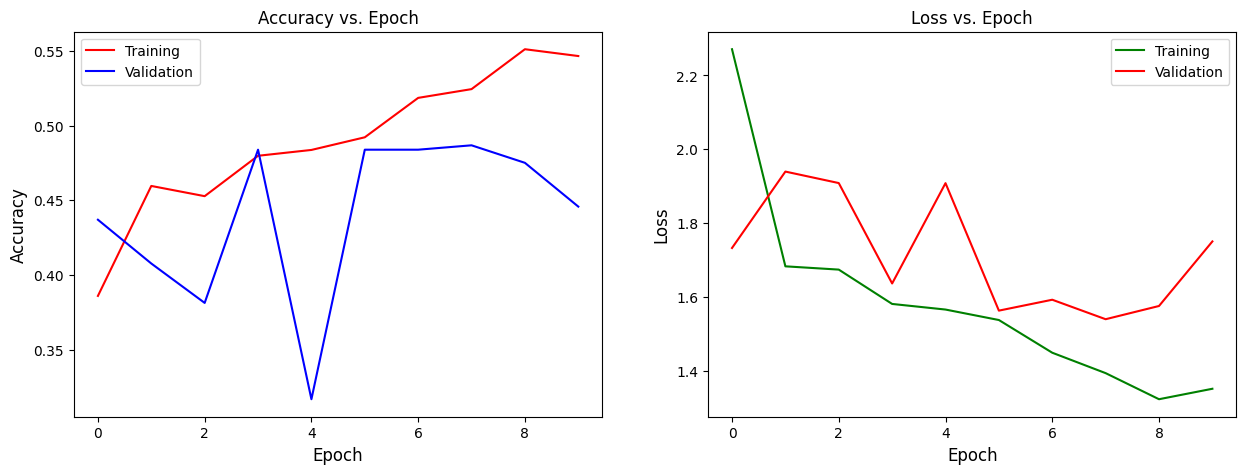

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(0,params['epochs']), history['accuracy'], label='Training', color='r')
plt.plot(range(0,params['epochs']), history['val_accuracy'], label='Validation', color='b')
plt.title('Accuracy vs. Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0,params['epochs']), history['loss'], label='Training', color='g')
plt.plot(range(0,params['epochs']), history['val_loss'], label='Validation', color='r')
plt.title('Loss vs. Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.show()

#### Performance on Test Data

In [22]:
y_pred = model.predict(test_ds)
y_pred

12/12 [==============================] - 3s 213ms/step


array([[2.5923246e-01, 2.3168523e-02, 1.2115083e-01, ..., 6.2217206e-02,
        1.3266428e-01, 3.0600831e-01],
       [4.2335889e-01, 1.5118016e-03, 2.6305872e-03, ..., 5.0902776e-02,
        3.4814890e-02, 3.8501211e-03],
       [2.4818507e-01, 2.0294506e-02, 3.3243012e-02, ..., 1.3150017e-01,
        7.8987166e-02, 2.5597567e-02],
       ...,
       [5.4241903e-04, 5.8332726e-06, 3.1763414e-04, ..., 4.2491070e-07,
        1.1232346e-06, 9.9912387e-01],
       [7.4027479e-02, 1.6149646e-03, 1.5567190e-03, ..., 6.9148101e-02,
        1.6589558e-02, 1.5099839e-03],
       [2.8411713e-03, 4.9424072e-04, 5.8783032e-03, ..., 2.0247554e-04,
        3.5307140e-04, 9.8807716e-01]], dtype=float32)

In [23]:
# get list of predicted classes by taking argmax of the probabilities(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)

# create list of all "y"s labels, by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 37.903225806451616


#### Simple Neural Network shows extreme poor performance. Why??
- MLP flattens the image. It is not position invariant, hence not considering the neighbouring pixels and the Image channels (R-G-B)
- MLP doesnot consider Spatial relations. Spatial Information (like if a Person is standing at the right side of the Car or The red car is on the left side of the blue bike) gets lost when the image is flattened
- MLP is a fully connected model, it requires a neuron for every input pixel of the image. Thus, it includes many parameters

<hr>

### **Convolutional Neural Network**

In [32]:
num_classes = 10
hidden_layer_cnn = 256

model = keras.Sequential(name='CNN_Model', layers=[
                  layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(height, width, 3)),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(hidden_layer_cnn, activation='relu'),
                  layers.Dense(num_classes, activation='softmax')
])

To visualize the Model Structure, run the below cell in Google Colab

In [33]:
# tf.keras.utils.plot_model(model, to_file='CNN_Model.png', show_shapes=True)

In [34]:
model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               16777472  
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16780490 (64.01 MB)
Trainable params: 16780490 (64.01 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [35]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
epochs = 10
model_fit_cnn = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 [==============================] - 40s 401ms/step - loss: 2.9074 - accuracy: 0.3334 - val_loss: 1.7683 - val_accuracy: 0.4428
Epoch 2/10
96/96 [==============================] - 41s 424ms/step - loss: 1.3478 - accuracy: 0.5711 - val_loss: 1.4718 - val_accuracy: 0.5630
Epoch 3/10
96/96 [==============================] - 44s 458ms/step - loss: 0.8824 - accuracy: 0.7288 - val_loss: 1.3544 - val_accuracy: 0.5543
Epoch 4/10
96/96 [==============================] - 43s 433ms/step - loss: 0.5431 - accuracy: 0.8491 - val_loss: 1.2731 - val_accuracy: 0.5982
Epoch 5/10
96/96 [==============================] - 42s 435ms/step - loss: 0.3278 - accuracy: 0.9214 - val_loss: 1.4168 - val_accuracy: 0.5777
Epoch 6/10
96/96 [==============================] - 40s 412ms/step - loss: 0.1790 - accuracy: 0.9664 - val_loss: 1.4769 - val_accuracy: 0.5894
Epoch 7/10
96/96 [==============================] - 43s 442ms/step - loss: 0.0987 - accuracy: 0.9876 - val_loss: 1.5660 - val_accuracy: 0.6070

### Performace Check

In [37]:
params_cnn = model_fit_cnn.params

In [38]:
history_cnn = model_fit_cnn.history

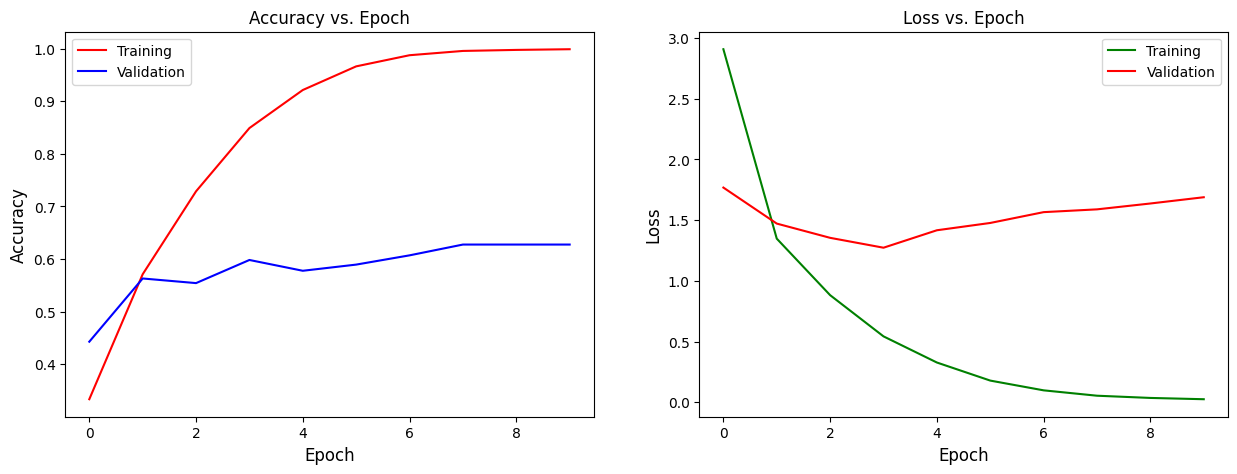

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(0,params_cnn['epochs']), history_cnn['accuracy'], label='Training', color='r')
plt.plot(range(0,params_cnn['epochs']), history_cnn['val_accuracy'], label='Validation', color='b')
plt.title('Accuracy vs. Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0,params_cnn['epochs']), history_cnn['loss'], label='Training', color='g')
plt.plot(range(0,params_cnn['epochs']), history_cnn['val_loss'], label='Validation', color='r')
plt.title('Loss vs. Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.show()

#### Performance on Test Data

In [48]:
y_pred = model.predict(test_ds)
y_pred

12/12 [==============================] - 2s 117ms/step


array([[0.1102883 , 0.1327453 , 0.09890467, ..., 0.0619891 , 0.18974963,
        0.07457782],
       [0.16858289, 0.11593232, 0.09713749, ..., 0.06155862, 0.16675533,
        0.0692169 ],
       [0.14523707, 0.10839257, 0.1063638 , ..., 0.05526255, 0.20243178,
        0.08513571],
       ...,
       [0.17030926, 0.09304426, 0.12096122, ..., 0.07292525, 0.20673925,
        0.09755264],
       [0.13845114, 0.11112579, 0.0851547 , ..., 0.05572436, 0.20545708,
        0.08519847],
       [0.14432961, 0.11817189, 0.07365111, ..., 0.06326037, 0.23631285,
        0.07185528]], dtype=float32)

In [41]:
# get list of predicted classes by taking argmax of the probabilities(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)

# create list of all "y"s labels, by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 49.46236559139785


### **Observation:**
- A big jump in the performance of CNN is observed
- MLP performs poor on training, validation and test data
- CNN performs well on training data increasing the validation accuracy and decreasing the loss as compared to MLP
- By adding a single Covolutional and MaxPool layer to the existing network, test accuracy increases from 37% to 49%
- CNN model proves to be more effective than simple NN